In [ ]:
# Mount Google Drive, load API keys for Quandl, and set up environment variables for API access
from google.colab import drive
import json

drive.mount('/content/drive')

from pathlib import Path
data_path = Path('drive', 'MyDrive', 'ML4T', 'data.h5')
assets_path = Path('drive', 'MyDrive', 'ML4T', 'assets.h5')

Mounted at /content/drive


In [ ]:
!pip install alphalens-reloaded

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 14.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.9/62.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.2/356.2 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.5 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.3-cp310-cp310-linux_x86_64.whl size=727577 sha256=2576734e2f3a572f3fbf958565f40bf4b7b4046bfa809e6ee80bf12e9b11ea82
  Stored in directory: /root/.cache/pip/wheels/0d/32/b7/cad9f818b37cf97df4c87a8308da86a433af81651d98f8d8aa
Successfully built peewee
  Attempting uninstall: peewee
    Found existing installation: peewee 3.17.6
    Uninstalling peewee-3.17.6:
      Successfully uninstalled peewee-3.17.6


# Alphalens Analysis

This notebook demonstrates how to use Alphalens to evaluate trading signals generated by different regression models.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import pandas as pd
from alphalens.tears import create_summary_tear_sheet
from alphalens.utils import get_clean_factor_and_forward_returns

# Use pandas IndexSlice for more convenient indexing
idx = pd.IndexSlice

## Load Data

We'll load prediction results from various regression models that we've previously trained and saved.

In [ ]:
# Load prediction and score data for linear regression, lasso, and ridge models
with pd.HDFStore(data_path) as store:
    lr_predictions = store['lr/predictions']
    lasso_predictions = store['lasso/predictions']
    lasso_scores = store['lasso/scores']
    ridge_predictions = store['ridge/predictions']
    ridge_scores = store['ridge/scores']

# Define path to asset data
DATA_STORE = assets_path

# Helper function to get trade prices for a set of tickers over a date range
def get_trade_prices(tickers, start, stop):
    # Load price data from HDF store
    prices = (pd.read_hdf(DATA_STORE, 'quandl/wiki/prices').swaplevel().sort_index())
    prices.index.names = ['symbol', 'date']

    # Select adjusted open prices for specified tickers and date range
    prices = prices.loc[idx[tickers, str(start):str(stop)], 'adj_open']

    # Reshape data, shift prices forward by 1 day, and localize timezone
    return (prices
            .unstack('symbol')
            .sort_index()
            .shift(-1)
            .tz_localize('UTC'))

# Helper function to get the best alpha value based on mean IC score
def get_best_alpha(scores):
    return scores.groupby('alpha').ic.mean().idxmax()

# Helper function to reshape factor data for Alphalens
def get_factor(predictions):
    return (predictions.unstack('symbol')
            .dropna(how='all')
            .stack()
            .tz_localize('UTC', level='date')
            .sort_index())

## Linear Regression

First, we'll analyze the results from the linear regression model.

In [ ]:
# Prepare linear regression factor data
lr_factor = get_factor(lr_predictions.predicted.swaplevel())
lr_factor.head()

date                       symbol
2014-12-09 00:00:00+00:00  AAL       0.000717
                           AAPL     -0.001252
                           ABBV      0.001393
                           AIG      -0.000731
                           AMAT     -0.000424
dtype: float64

In [ ]:
# Get unique tickers from the factor data
tickers = lr_factor.index.get_level_values('symbol').unique()

# Load trade prices for these tickers
trade_prices = get_trade_prices(tickers, 2014, 2017)
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1007 entries, 2014-01-02 00:00:00+00:00 to 2017-12-29 00:00:00+00:00
Columns: 250 entries, AAL to MAT
dtypes: float64(250)
memory usage: 1.9 MB


In [ ]:
# Prepare factor data for Alphalens
lr_factor_data = get_clean_factor_and_forward_returns(factor=lr_factor,
                                                      prices=trade_prices,
                                                      quantiles=5,
                                                      periods=(1, 5, 10, 21))
lr_factor_data.info()

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 74029 entries, (Timestamp('2014-12-09 00:00:00+0000', tz='UTC'), 'AAL') to (Timestamp('2017-11-29 00:00:00+0000', tz='UTC'), 'XOM')
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   1D               74029 non-null  float64
 1   5D               74029 non-null  float64
 2   10D              74029 non-null  float64
 3   21D              74029 non-null  float64
 4   factor           74029 non-null  float64
 5   factor_quantile  74029 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 3.7+ MB


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.045781,0.009490,-0.003070,0.004172,14982,20.238015
2,-0.014869,0.011747,-0.000895,0.003348,14856,20.067811
3,-0.013620,0.013408,0.000189,0.003367,14354,19.389699
4,-0.012061,0.015815,0.001219,0.003464,14856,20.067811
5,-0.010128,0.036732,0.003338,0.004292,14981,20.236664


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.059,0.070,0.054,0.019
beta,0.002,-0.098,-0.074,0.002
Mean Period Wise Return Top Quantile (bps),2.454,2.805,2.017,1.193
Mean Period Wise Return Bottom Quantile (bps),-2.562,-1.422,-0.885,-0.332
Mean Period Wise Spread (bps),5.016,4.249,2.917,1.502


Information Analysis


,1D,5D,10D,21D
IC Mean,0.018,0.019,0.021,0.021
IC Std.,0.177,0.170,0.175,0.163
Risk-Adjusted IC,0.104,0.111,0.120,0.126
t-stat(IC),2.853,3.034,3.276,3.462
p-value(IC),0.004,0.002,0.001,0.001
IC Skew,-0.039,-0.053,-0.038,-0.041
IC Kurtosis,-0.128,0.024,-0.215,-0.125


Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.301,0.519,0.640,0.739
Quantile 2 Mean Turnover,0.525,0.706,0.761,0.792
Quantile 3 Mean Turnover,0.570,0.736,0.784,0.810
Quantile 4 Mean Turnover,0.521,0.698,0.759,0.793
Quantile 5 Mean Turnover,0.298,0.517,0.649,0.753


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.818,0.566,0.371,0.211


<Figure size 640x480 with 0 Axes>

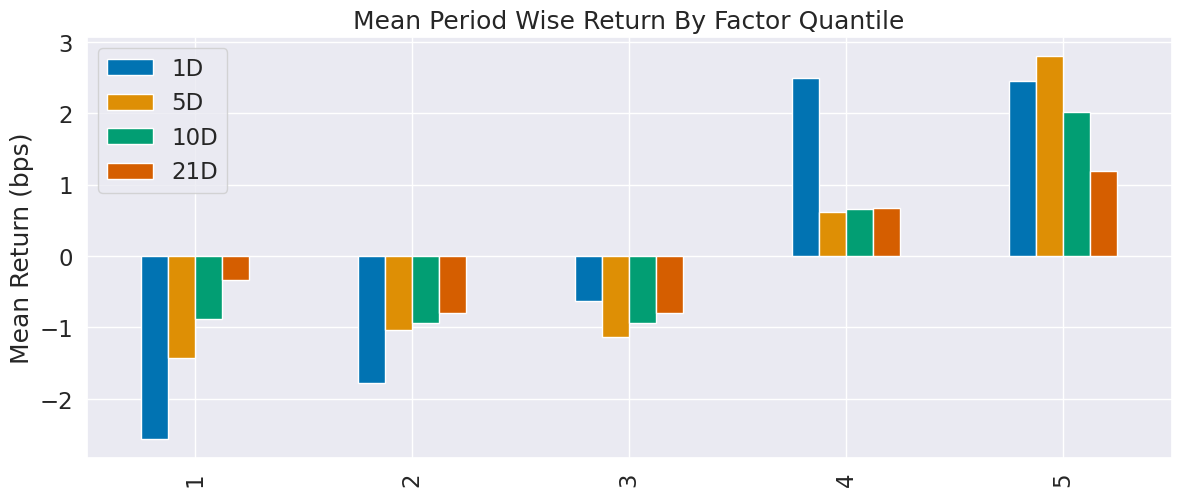

In [ ]:
# Generate Alphalens summary tear sheet
create_summary_tear_sheet(lr_factor_data)

## Ridge Regression

Next, we'll analyze the results from the ridge regression model.

In [ ]:
# Get best alpha value for ridge regression
best_ridge_alpha = get_best_alpha(ridge_scores)
ridge_predictions = ridge_predictions[ridge_predictions.alpha==best_ridge_alpha].drop('alpha', axis=1)


In [ ]:
# Prepare ridge regression factor data
ridge_factor = get_factor(ridge_predictions.predicted.swaplevel())
ridge_factor.head()

date                       symbol
2014-12-09 00:00:00+00:00  AAL       0.000977
                           AAPL     -0.001029
                           ABBV      0.001268
                           AIG      -0.000805
                           AMAT     -0.000462
dtype: float64

In [ ]:
# Prepare factor data for Alphalens
ridge_factor_data = get_clean_factor_and_forward_returns(factor=ridge_factor,
                                                         prices=trade_prices,
                                                         quantiles=5,
                                                         periods=(1, 5, 10, 21))
ridge_factor_data.info()

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 74029 entries, (Timestamp('2014-12-09 00:00:00+0000', tz='UTC'), 'AAL') to (Timestamp('2017-11-29 00:00:00+0000', tz='UTC'), 'XOM')
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   1D               74029 non-null  float64
 1   5D               74029 non-null  float64
 2   10D              74029 non-null  float64
 3   21D              74029 non-null  float64
 4   factor           74029 non-null  float64
 5   factor_quantile  74029 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 3.7+ MB


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.036759,0.009918,-0.003291,0.003674,14982,20.238015
2,-0.012530,0.012043,-0.001275,0.003056,14856,20.067811
3,-0.010864,0.013707,-0.000247,0.003114,14354,19.389699
4,-0.009438,0.015985,0.000718,0.003248,14856,20.067811
5,-0.007983,0.035922,0.002661,0.004073,14981,20.236664


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.056,0.069,0.056,0.022
beta,0.001,-0.090,-0.065,0.011
Mean Period Wise Return Top Quantile (bps),2.098,2.888,2.215,1.331
Mean Period Wise Return Bottom Quantile (bps),-3.176,-1.395,-1.031,-0.360
Mean Period Wise Spread (bps),5.275,4.307,3.264,1.674


Information Analysis


,1D,5D,10D,21D
IC Mean,0.019,0.021,0.024,0.022
IC Std.,0.179,0.171,0.175,0.162
Risk-Adjusted IC,0.108,0.122,0.135,0.135
t-stat(IC),2.964,3.342,3.705,3.688
p-value(IC),0.003,0.001,0.000,0.000
IC Skew,-0.046,-0.071,-0.074,-0.059
IC Kurtosis,-0.090,-0.023,-0.169,-0.105


Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.295,0.510,0.633,0.735
Quantile 2 Mean Turnover,0.515,0.699,0.762,0.792
Quantile 3 Mean Turnover,0.562,0.735,0.787,0.806
Quantile 4 Mean Turnover,0.515,0.696,0.757,0.789
Quantile 5 Mean Turnover,0.299,0.514,0.650,0.753


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.819,0.578,0.381,0.219


<Figure size 640x480 with 0 Axes>

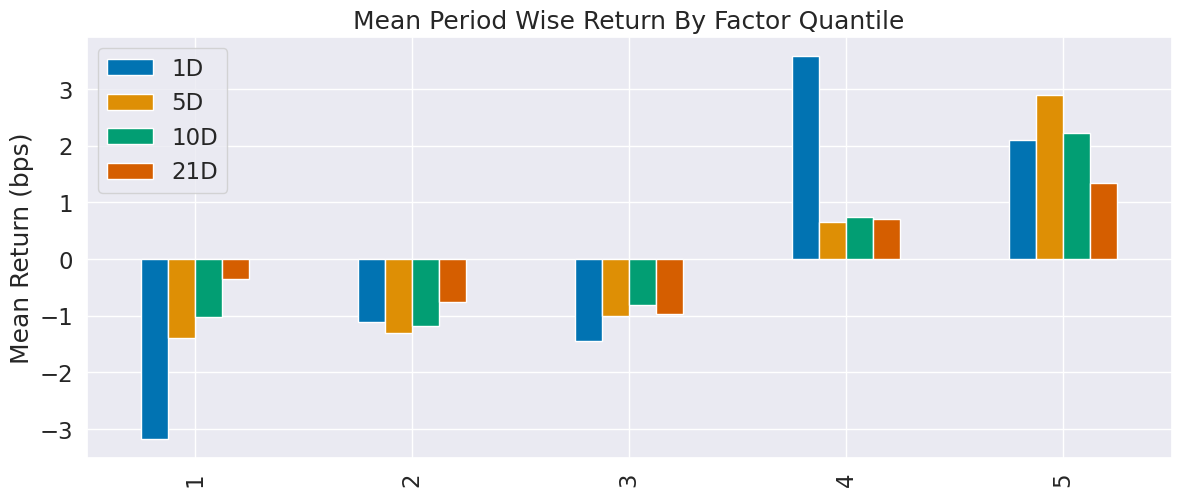

In [ ]:
# Generate Alphalens summary tear sheet
create_summary_tear_sheet(ridge_factor_data)

## Lasso Regression

Finally, we'll analyze the results from the lasso regression model.

In [ ]:
# Get best alpha value for lasso regression
best_lasso_alpha = get_best_alpha(lasso_scores)
lasso_predictions = lasso_predictions[lasso_predictions.alpha==best_lasso_alpha].drop('alpha', axis=1)


In [ ]:
# Prepare lasso regression factor data
lasso_factor = get_factor(lasso_predictions.predicted.swaplevel())
lasso_factor.head()

date                       symbol
2014-12-09 00:00:00+00:00  AAL       0.000783
                           AAPL     -0.001101
                           ABBV      0.001316
                           AIG      -0.000860
                           AMAT     -0.000524
dtype: float64

In [ ]:
# Prepare factor data for Alphalens
lasso_factor_data = get_clean_factor_and_forward_returns(factor=lasso_factor,
                                                      prices=trade_prices,
                                                      quantiles=5,
                                                      periods=(1, 5, 10, 21))
lasso_factor_data.info()

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 74029 entries, (Timestamp('2014-12-09 00:00:00+0000', tz='UTC'), 'AAL') to (Timestamp('2017-11-29 00:00:00+0000', tz='UTC'), 'XOM')
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   1D               74029 non-null  float64
 1   5D               74029 non-null  float64
 2   10D              74029 non-null  float64
 3   21D              74029 non-null  float64
 4   factor           74029 non-null  float64
 5   factor_quantile  74029 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 3.7+ MB


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.042493,0.009962,-0.003380,0.003883,14982,20.238015
2,-0.013790,0.012056,-0.001288,0.003219,14856,20.067811
3,-0.011897,0.013774,-0.000225,0.003305,14354,19.389699
4,-0.010828,0.016169,0.000771,0.003455,14856,20.067811
5,-0.008734,0.039549,0.002804,0.004337,14981,20.236664


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.057,0.068,0.054,0.021
beta,0.003,-0.090,-0.061,0.015
Mean Period Wise Return Top Quantile (bps),2.870,3.002,2.221,1.348
Mean Period Wise Return Bottom Quantile (bps),-2.845,-1.523,-1.113,-0.380
Mean Period Wise Spread (bps),5.716,4.547,3.350,1.705


Information Analysis


,1D,5D,10D,21D
IC Mean,0.019,0.020,0.023,0.022
IC Std.,0.178,0.171,0.175,0.163
Risk-Adjusted IC,0.106,0.119,0.131,0.135
t-stat(IC),2.902,3.249,3.580,3.694
p-value(IC),0.004,0.001,0.000,0.000
IC Skew,-0.034,-0.067,-0.055,-0.049
IC Kurtosis,-0.120,0.017,-0.186,-0.128


Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.297,0.518,0.638,0.738
Quantile 2 Mean Turnover,0.520,0.705,0.762,0.792
Quantile 3 Mean Turnover,0.567,0.737,0.785,0.805
Quantile 4 Mean Turnover,0.519,0.699,0.755,0.790
Quantile 5 Mean Turnover,0.300,0.517,0.650,0.755


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.818,0.569,0.374,0.213


<Figure size 640x480 with 0 Axes>

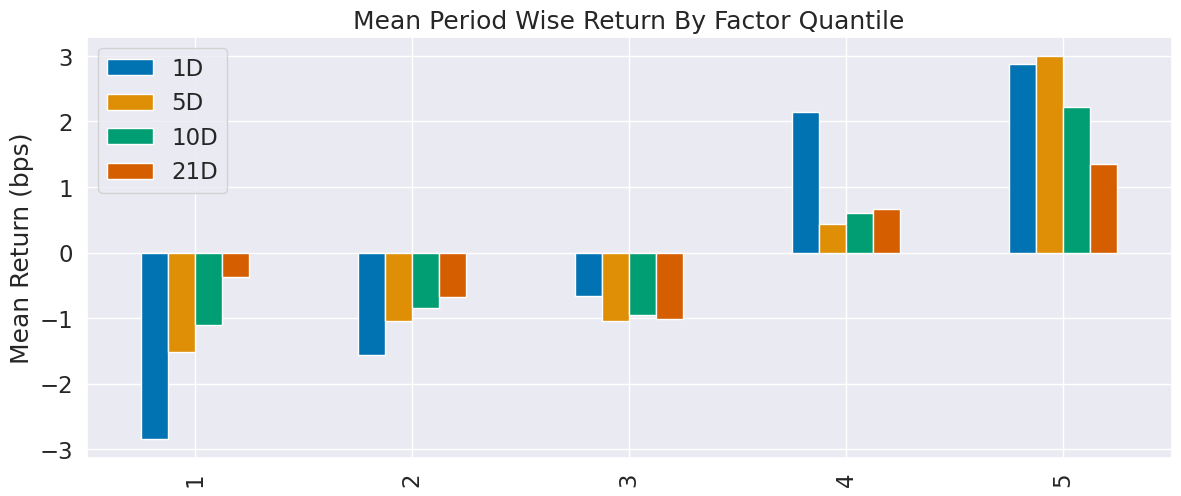

In [ ]:
# Generate Alphalens summary tear sheet
create_summary_tear_sheet(lasso_factor_data)